<a href="https://colab.research.google.com/github/jduell12/DS-Unit-2-Linear-Models/blob/master/C_212_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Libraries for R^2 visualization
from ipywidgets import interactive, IntSlider, FloatSlider
from math import floor, ceil
from sklearn.base import BaseEstimator, RegressorMixin

# Libraries for model building
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Library for working locally or Colab
import sys

In [31]:
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'

# I. Wrangle Data

In [46]:
def wrangle(filepath):
  #read in the data
  df = pd.read_csv(filepath, index_col='Year')
  #rename the columns
  df.columns = df.columns.str.replace(' ', '_')
  #drop two high cardinality categorical variables
  df = df.drop(columns=['Incumbent_Party_Candidate', 'Other_Candidate'])
  df.columns = ['income', 'fatalities', 'incumbent_vote_share']
  return df

df = wrangle(DATA_PATH + 'elections/bread_peace_voting.csv')
df.head()

,income,fatalities,incumbent_vote_share
Year,,,
1952,2.40,190,44.60
1956,2.89,0,57.76
1960,0.85,0,49.91
1964,4.21,1,61.34
1968,3.02,146,49.60


Let's visualize the relationship between vote share and incomes

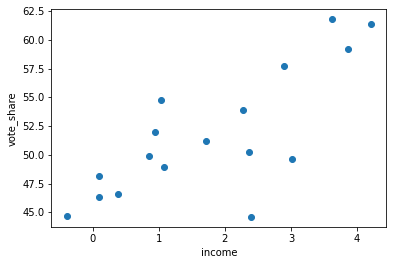

In [47]:
plt.scatter(df['income'], df['incumbent_vote_share']);
plt.xlabel('income')
plt.ylabel('vote_share');

Let's visualize the relationship between vote share and fatalities 

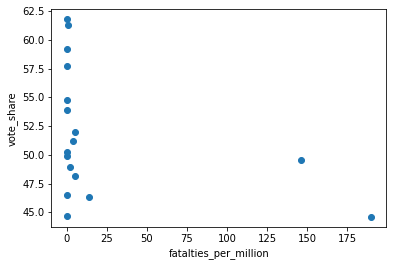

In [48]:
plt.scatter( df['fatalities'],df['incumbent_vote_share'])
plt.ylabel('vote_share')
plt.xlabel('fatalties_per_million');

# II. Split Data

**First** we need to split our **target vector** from our **feature matrix**.

In [49]:
target = 'incumbent_vote_share'

# target vector
y = df[target]

# feature matrix
X = df.drop(columns=target)

X.head()

,income,fatalities
Year,,
1952,2.40,190
1956,2.89,0
1960,0.85,0
1964,4.21,1
1968,3.02,146


**Second** we need to split our dataset into **training** and **test** sets.

Two strategies:

- Random train-test split using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Generally we use 80% of the data for training, and 20% of the data for testing.
- If you have **timeseries**, then you need to do a "cutoff" split.

In [51]:
X.index.min()

1952

In [52]:
# train on data before 2008 and test on data from 2008-present 
cutoff = 2008
mask = X.index < 2008
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [53]:
~mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True])

In [54]:
X_train

,income,fatalities
Year,,
1952,2.40,190
1956,2.89,0
1960,0.85,0
1964,4.21,1
1968,3.02,146
1972,3.62,0
1976,1.08,2
1980,-0.39,0
1984,3.86,0


In [55]:
X_test

,income,fatalities
Year,,
2008,0.10,14
2012,0.95,5
2016,0.10,5


# III. Establish Baseline

In [58]:
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)
print('Mean Vote share:', y_train.mean())
print('Baseline MAE:', baseline_mae)

Mean Vote share: 52.46857142857142
Baseline MAE: 4.846938775510204


# IV. Build Model

In [61]:
# Step 1: Import predictor class
# Did it above 

# Step 2: Instantiate your model (class --> object)
model = LinearRegression()

# Step 3: Fit your TRAINING data to the model
model.fit(X_train, y_train);

# V. Check Metrics

## Mean Absolute Error

The unit of measurement is the same as the unit of measurment for your target (in this case, vote share [%]).

In [63]:
print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('Test MAE:', mean_absolute_error(y_test, model.predict(X_test)))

Training MAE: 1.3303221006874268
Test MAE: 1.6341722692537293


Want the test MAE to be similar to the training MAE. Will usually be slightly worse but as long as it's in the same general area we can say the model can generalize.

## Root Mean Squared Error

In [66]:
print('Training RSME:', mean_squared_error(y_train, model.predict(X_train), squared=False))
print('Test RSME:', mean_squared_error(y_test, model.predict(X_test), squared=False))

Training RSME: 1.9823427386821593
Test RSME: 1.8613616351898397


## $R^2$ Score

TL;DR: Usually ranges between 0 (bad) and 1 (good).

In [67]:
class BruteForceRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, m=0, b=0):
        self.m = m
        self.b = b
        self.mean = 0
        
    def fit(self, X, y):
        self.mean = np.mean(y)
        return self
    
    def predict(self, X, return_mean=True):
        if return_mean:
            return [self.mean] * len(X)
        else:
            return X * self.m + self.b

def plot(slope, intercept):
    # Assign data to variables
    x = df['income']
    y = df['incumbent_vote_share']
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    
    # Set ax limits
    mar = 0.2
    x_lim = floor(x.min() - x.min()*mar), ceil(x.max() + x.min()*mar)
    y_lim = floor(y.min() - y.min()*mar), ceil(y.max() + y.min()*mar)
    
    # Instantiate and train model
    bfr = BruteForceRegressor(slope, intercept)
    bfr.fit(x, y)
    
    # ax1   
    ## Plot data
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)
    ax1.scatter(x, y)
    
    ## Plot base model
    ax1.axhline(bfr.mean, color='orange', label='baseline model')
    
    ## Plot residual lines
    y_base_pred = bfr.predict(x)
    ss_base = mean_squared_error(y, y_base_pred) * len(y)
    for x_i, y_i, yp_i in zip(x, y, y_base_pred):
        ax1.plot([x_i, x_i], [y_i, yp_i], 
                 color='gray', linestyle='--', alpha=0.75)
    
    ## Formatting
    ax1.legend()
    ax1.set_title(f'Sum of Squares: {np.round(ss_base, 2)}')
    ax1.set_xlabel('Growth in Personal Incomes')
    ax1.set_ylabel('Incumbent Party Vote Share [%]')

    # ax2

    ax2.set_xlim(x_lim)
    ax2.set_ylim(y_lim)
    ## Plot data
    ax2.scatter(x, y)
    
    ## Plot model
    x_model = np.linspace(*ax2.get_xlim(), 10)
    y_model = bfr.predict(x_model, return_mean=False)
    ax2.plot(x_model, y_model, color='green', label='our model')
    for x_coord, y_coord in zip(x, y):
        ax2.plot([x_coord, x_coord], [y_coord, x_coord * slope + intercept], 
                 color='gray', linestyle='--', alpha=0.75)   
    
    ss_ours = mean_squared_error(y, bfr.predict(x, return_mean=False)) * len(y)
    
    ## Formatting
    ax2.legend()
    ax2.set_title(f'Sum of Squares: {np.round(ss_ours, 2)}')
    ax2.set_xlabel('Growth in Personal Incomes')
    ax2.set_ylabel('Incumbent Party Vote Share [%]')

y = df['incumbent_vote_share']
slope_slider = FloatSlider(min=-5, max=5, step=0.5, value=0)
intercept_slider = FloatSlider(min=int(y.min()), max=y.max(), step=2, value=y.mean())
    
interactive(plot, slope=slope_slider, intercept=intercept_slider)

interactive(children=(FloatSlider(value=0.0, description='slope', max=5.0, min=-5.0, step=0.5), FloatSlider(va…

In [72]:
print('Training R^2:', model.score(X_train, y_train))
print('Test R^2:', model.score(X_test, y_test))

Training R^2: 0.8739958896016927
Test R^2: 0.3792995526663848


# VI. Communicate Results

**Challenge:** How can we find the coefficients and intercept for our `model`?